In [1]:
import django
django.setup()

In [61]:
import os
from DatasetAnnotator.models import Posts
from django.db.models import Q
from django.conf import settings
import numpy as np
import glob
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

# Threads length

In [3]:
available_dbs = settings.DATABASES.keys()[1:]

# example: {'cooking':[1,2,1,2,5], 'webapps': [...] ....}
threads_length = dict()

for db in available_dbs:
    os.write(1, db+"\n")
    threads_length[db] = []
    
    questions_id_list = Posts.objects\
        .using(db)\
        .filter(posttypeid=1)\
        .values_list('id', flat=True)
    
    for question_id in questions_id_list:
        #os.write(1, str(question_id)+" ")
        answers_count = Posts.objects \
        .using(db)\
        .filter(parentid=question_id)\
        .count()
        
        threads_length[db].append(answers_count + 1)

# Thread length VS Nr threads

In [8]:
# for each distinct value in [...] count its occurence, zip the result

t_length_count = dict()

for db in available_dbs:    
    # count occurences
    bins = np.bincount(threads_length[db])
    # remove zeros from bins
    t_count = bins[np.nonzero(bins)]
    # sorted threads sizes
    t_sizes = np.unique(threads_length[db])
    
    t_length_count[db] = {
        't_count': t_count,
        't_sizes': t_sizes
    }

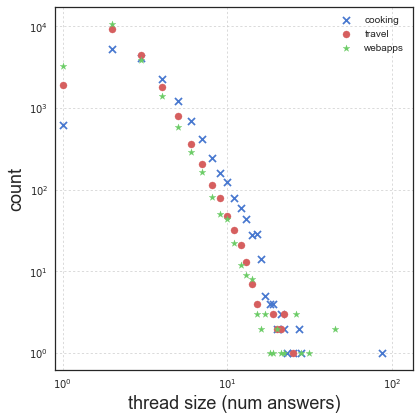

In [57]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=t_length_count['cooking']['t_sizes'], y=t_length_count['cooking']['t_count'], label='cooking', s=50, c='b', marker='x', clip_on=False)
ax1.scatter(x=t_length_count['travel']['t_sizes'], y=t_length_count['travel']['t_count'], label='travel', s=50, c='r', marker='o', clip_on=False)
ax1.scatter(x=t_length_count['webapps']['t_sizes'], y=t_length_count['webapps']['t_count'], label='webapps', s=50, c='g', marker='*', clip_on=False)

ax1.set_xscale('log', nonposx='clip')
ax1.set_yscale('log', nonposy='clip')
plt.xlabel('thread size (num answers)', fontsize=18)
plt.ylabel('count', fontsize=18)
ax1.set_xlim(xmin=0.9)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend()
plt.tight_layout()

# Annotations distribution

In [71]:
base_path = 'annotations_backups/'

# get the latest csv, per db
cooking_path = sorted(glob.glob(base_path + 'cooking_*.csv'))[-1:][0]
travel_path = sorted(glob.glob(base_path + 'travel_*.csv'))[-1:][0]
webapps_path = sorted(glob.glob(base_path + 'webapps_*.csv'))[-1:][0]

cooking_df = pd.read_csv(cooking_path, index_col='id')
travel_df = pd.read_csv(travel_path,  index_col='id')
webapps_df = pd.read_csv(webapps_path,  index_col='id')

cooking_ann_dist = cooking_df.max(axis=1)
travel_ann_dist = travel_df.max(axis=1)
webapps_ann_dist = webapps_df.max(axis=1)

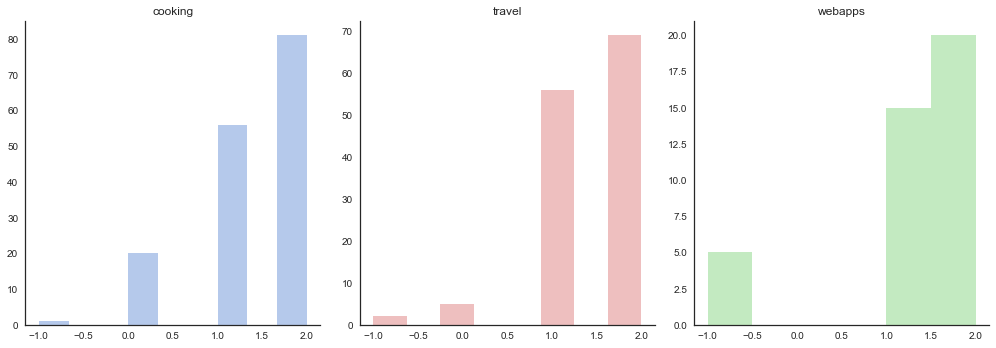

In [72]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.despine()

g = sns.distplot(a=cooking_ann_dist, kde=False, color="b", ax=axes[0])
g.axes.set_title('cooking')
g = sns.distplot(a=travel_ann_dist, kde=False, color="r", ax=axes[1])
g.axes.set_title('travel')
g = sns.distplot(a=webapps_ann_dist, kde=False, color="g", ax=axes[2])
g.axes.set_title('webapps')

plt.tight_layout()

# Counting of questions/answers

In [11]:
items_counting = {
    'whole_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    },
    'annotated_data': {
        'cooking': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'webapps': {
            'questions': -1,
            'answers': -1,
            'other': -1
        },
        'travel': {
            'questions': -1,
            'answers': -1,
            'other': -1
        }
    }
}

# total nr of questions
for db in available_dbs:
    items_counting['whole_data'][db]['questions'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=1) \
            .count()

# Total nr. of answers
for db in available_dbs:
    items_counting['whole_data'][db]['answers'] = \
        Posts.objects \
            .using(db) \
            .filter(posttypeid=2) \
            .count()

# Total nr. of other posts
for db in available_dbs:
    items_counting['whole_data'][db]['other'] = \
        Posts.objects \
            .using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .count()

# counting annotated questions
for db in available_dbs:
    items_counting['annotated_data'][db]['questions'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=1) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

# counting annotated answers
for db in available_dbs:
    items_counting['annotated_data'][db]['answers'] = \
        Posts.objects.using(db) \
            .filter(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

# counting annotated others
for db in available_dbs:
    items_counting['annotated_data'][db]['others'] = \
        Posts.objects.using(db) \
            .exclude(posttypeid=1) \
            .exclude(posttypeid=2) \
            .filter(Q(annotatedqualityenrico__isnull=False) | \
                    Q(annotatedqualitymarit__isnull=False) | \
                    Q(annotatedqualitychristine__isnull=False) | \
                    Q(annotatedqualityhenrik__isnull=False)) \
            .count()

In [14]:
print items_counting

{'annotated_data': {'webapps': {'other': -1, 'answers': 0, 'questions': 0}, 'travel': {'other': -1, 'answers': 0, 'questions': 0}, 'cooking': {'other': -1, 'answers': 0, 'questions': 0}}, 'whole_data': {'webapps': {'other': 1353, 'answers': 29881, 'questions': 20573}, 'travel': {'other': 3386, 'answers': 32915, 'questions': 19279}, 'cooking': {'other': 453, 'answers': 38709, 'questions': 15404}}}


# Nr answers and nr questions, per user

In [37]:
# note: ids are non-negative integers
users_activity = {
    'whole_data': {
        'cooking': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        },
        'webapps': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        },
        'travel': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        }
    },
    'annotated_data': {
        'cooking': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        },
        'webapps': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        },
        'travel': {
            '-99': {
                'nr_questions': -1,
                'nr_answers': -1
            }   
        }
    }
}

from django.db.models import Count, Min, Max


#TODO: first populate users_activity with existing owneruserid-s, then fill it with query below
for db in available_dbs:
    # questions
    print \
        Posts.objects.using(db)\
        .filter(posttypeid=1)\
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(nr_questions=Count('owneruserid'))
    
    # answers
    print \
        Posts.objects.using(db)\
        .filter(posttypeid=2)\
        .order_by()\
        .values('owneruserid')\
        .distinct()\
        .annotate(nr_questions=Count('owneruserid'))

<QuerySet [{'owneruserid': 17L, 'nr_questions': 13}, {'owneruserid': 20L, 'nr_questions': 6}, {'owneruserid': 23L, 'nr_questions': 5}, {'owneruserid': 21L, 'nr_questions': 26}, {'owneruserid': 29L, 'nr_questions': 5}, {'owneruserid': 40L, 'nr_questions': 118}, {'owneruserid': 32L, 'nr_questions': 4}, {'owneruserid': 84L, 'nr_questions': 1}, {'owneruserid': 53L, 'nr_questions': 5}, {'owneruserid': 78L, 'nr_questions': 3}, {'owneruserid': 91L, 'nr_questions': 2}, {'owneruserid': 69L, 'nr_questions': 4}, {'owneruserid': 82L, 'nr_questions': 4}, {'owneruserid': 95L, 'nr_questions': 2}, {'owneruserid': 108L, 'nr_questions': 12}, {'owneruserid': 88L, 'nr_questions': 47}, {'owneruserid': 117L, 'nr_questions': 4}, {'owneruserid': 107L, 'nr_questions': 6}, {'owneruserid': 111L, 'nr_questions': 13}, {'owneruserid': 119L, 'nr_questions': 7}, '...(remaining elements truncated)...']>


<QuerySet [{'owneruserid': 22L, 'nr_questions': 7}, {'owneruserid': 32L, 'nr_questions': 13}, {'owneruserid': 20L, 'nr_questions': 77}, {'owneruserid': 31L, 'nr_questions': 3}, {'owneruserid': 41L, 'nr_questions': 3}, {'owneruserid': 56L, 'nr_questions': 3}, {'owneruserid': 49L, 'nr_questions': 22}, {'owneruserid': 57L, 'nr_questions': 6}, {'owneruserid': 37L, 'nr_questions': 6}, {'owneruserid': 50L, 'nr_questions': 3}, {'owneruserid': None, 'nr_questions': 0}, {'owneruserid': 43L, 'nr_questions': 10}, {'owneruserid': 75L, 'nr_questions': 16}, {'owneruserid': 78L, 'nr_questions': 12}, {'owneruserid': 79L, 'nr_questions': 5}, {'owneruserid': 77L, 'nr_questions': 2}, {'owneruserid': 104L, 'nr_questions': 5}, {'owneruserid': 25L, 'nr_questions': 5}, {'owneruserid': 81L, 'nr_questions': 5}, {'owneruserid': 91L, 'nr_questions': 4}, '...(remaining elements truncated)...']>


<QuerySet [{'owneruserid': 9L, 'nr_questions': 1}, {'owneruserid': 13L, 'nr_questions': 4}, {'owneruserid': 24L, 'nr_questions': 4}, {'owneruserid': 19L, 'nr_questions': 25}, {'owneruserid': 26L, 'nr_questions': 265}, {'owneruserid': 23L, 'nr_questions': 6}, {'owneruserid': 10L, 'nr_questions': 3}, {'owneruserid': 30L, 'nr_questions': 39}, {'owneruserid': 22L, 'nr_questions': 1}, {'owneruserid': 27L, 'nr_questions': 1}, {'owneruserid': 34L, 'nr_questions': 5}, {'owneruserid': 8L, 'nr_questions': 1}, {'owneruserid': 28L, 'nr_questions': 7}, {'owneruserid': 33L, 'nr_questions': 7}, {'owneruserid': 51L, 'nr_questions': 1}, {'owneruserid': 11L, 'nr_questions': 14}, {'owneruserid': 44L, 'nr_questions': 83}, {'owneruserid': 60L, 'nr_questions': 18}, {'owneruserid': 59L, 'nr_questions': 8}, {'owneruserid': 63L, 'nr_questions': 5}, '...(remaining elements truncated)...']>


<QuerySet [{'owneruserid': 9L, 'nr_questions': 24}, {'owneruserid': 26L, 'nr_questions': 393}, {'owneruserid': 35L, 'nr_questions': 2}, {'owneruserid': 33L, 'nr_questions': 4}, {'owneruserid': 30L, 'nr_questions': 31}, {'owneruserid': 19L, 'nr_questions': 138}, {'owneruserid': 23L, 'nr_questions': 5}, {'owneruserid': 46L, 'nr_questions': 369}, {'owneruserid': 40L, 'nr_questions': 9}, {'owneruserid': 11L, 'nr_questions': 34}, {'owneruserid': 13L, 'nr_questions': 11}, {'owneruserid': 8L, 'nr_questions': 6}, {'owneruserid': 34L, 'nr_questions': 3}, {'owneruserid': 48L, 'nr_questions': 6}, {'owneruserid': 58L, 'nr_questions': 1}, {'owneruserid': 59L, 'nr_questions': 4}, {'owneruserid': 44L, 'nr_questions': 136}, {'owneruserid': 56L, 'nr_questions': 2}, {'owneruserid': 60L, 'nr_questions': 5}, {'owneruserid': 31L, 'nr_questions': 8}, '...(remaining elements truncated)...']>


<QuerySet [{'owneruserid': 16L, 'nr_questions': 11}, {'owneruserid': 17L, 'nr_questions': 4}, {'owneruserid': 14L, 'nr_questions': 2}, {'owneruserid': 24L, 'nr_questions': 6}, {'owneruserid': 21L, 'nr_questions': 6}, {'owneruserid': 27L, 'nr_questions': 44}, {'owneruserid': 18L, 'nr_questions': 1}, {'owneruserid': 29L, 'nr_questions': 1}, {'owneruserid': 26L, 'nr_questions': 1}, {'owneruserid': 38L, 'nr_questions': 1}, {'owneruserid': 3L, 'nr_questions': 1}, {'owneruserid': 36L, 'nr_questions': 3}, {'owneruserid': 22L, 'nr_questions': 2}, {'owneruserid': 43L, 'nr_questions': 12}, {'owneruserid': 39L, 'nr_questions': 1}, {'owneruserid': 50L, 'nr_questions': 1}, {'owneruserid': 2L, 'nr_questions': 2}, {'owneruserid': 57L, 'nr_questions': 2}, {'owneruserid': 64L, 'nr_questions': 4}, {'owneruserid': 44L, 'nr_questions': 2}, '...(remaining elements truncated)...']>


<QuerySet [{'owneruserid': 31L, 'nr_questions': 9}, {'owneruserid': 34L, 'nr_questions': 9}, {'owneruserid': 25L, 'nr_questions': 6}, {'owneruserid': 40L, 'nr_questions': 7}, {'owneruserid': 26L, 'nr_questions': 8}, {'owneruserid': 27L, 'nr_questions': 24}, {'owneruserid': 17L, 'nr_questions': 2}, {'owneruserid': 12L, 'nr_questions': 1}, {'owneruserid': 39L, 'nr_questions': 2}, {'owneruserid': 19L, 'nr_questions': 12}, {'owneruserid': 51L, 'nr_questions': 31}, {'owneruserid': 32L, 'nr_questions': 9}, {'owneruserid': 43L, 'nr_questions': 37}, {'owneruserid': 46L, 'nr_questions': 4}, {'owneruserid': 45L, 'nr_questions': 34}, {'owneruserid': 35L, 'nr_questions': 7}, {'owneruserid': 50L, 'nr_questions': 1}, {'owneruserid': 16L, 'nr_questions': 12}, {'owneruserid': 60L, 'nr_questions': 310}, {'owneruserid': 22L, 'nr_questions': 19}, '...(remaining elements truncated)...']>


In [ ]:
"""
# Set up the matplotlib figure
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(3, 1, figsize=(12, 7))
sns.despine(left=True)

sns.distplot(a=threads_length['cooking'], kde=False, color="b", ax=axes[0])
sns.distplot(a=threads_length['webapps'], kde=False, color="r", ax=axes[1])
sns.distplot(a=threads_length['travel'], kde=False, color="g", ax=axes[2])
plt.tight_layout()
"""